# First Case Study: Framing Climate Change 

In [1]:
import pandas as pd 
import numpy as np 
import seaborn as sns 
import urllib, json
sns.set_style('whitegrid')
from matplotlib import pyplot as plt 
import statsmodels.formula.api as smf 
import statsmodels.api as sm
import glob

/usr/local/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
# Load Files
files = glob.glob('data/climate_2017*')
dfs = []
for file in files:
    dfs.append(pd.read_pickle(file))
df = pd.concat(dfs).sort_index()

In [3]:
print("Total Number of Articles: {}".format(len(df)))

Total Number of Articles: 3043


### Source Comparisons

/usr/local/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


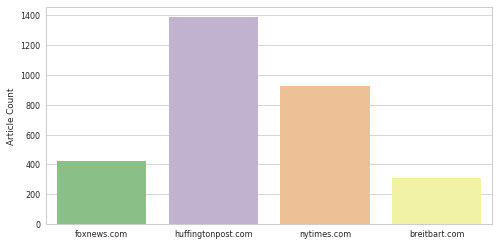

In [4]:
# How many articles per source  
plt.style.use('seaborn-paper')
fig, ax = plt.subplots(figsize=(8,4))
sns.countplot(x='source', data=df, ax=ax, palette='Accent')
plt.xlabel('')
plt.ylabel('Article Count')
plt.savefig('plots/source_counts.png', dpi=300)

#### Preparation of MFD and LIWC comparisons

In [5]:
cols = list(df.columns)

In [6]:
cols.remove('source')
cols.remove('tone')
cols.remove('url')
cols.remove('wc')

In [7]:
df[cols] = df[cols].divide(df['wc'],axis=0)

In [8]:
foundations = ['Care','Harm','Fairness','Cheating','Loyalty','Betrayal','Authority','Subversion','Purity','Degradation']

In [9]:
found = ['Care-Harm','Fairness-Cheating','Loyalty-Betrayal','Authority-Subversion','Purity-Degradation']

In [10]:
df['Care-Harm'] = df['Care'] + df['Harm']
df['Fairness-Cheating'] = df['Fairness'] + df['Cheating']
df['Loyalty-Betrayal'] = df['Loyalty'] + df['Betrayal']
df['Authority-Subversion'] = df['Authority'] + df['Subversion']
df['Purity-Degradation'] = df['Purity'] + df['Degradation']

In [11]:
df['PersonalConcerns'] = df['Death'] + df['Religion'] 

#### LIWC Comparisons

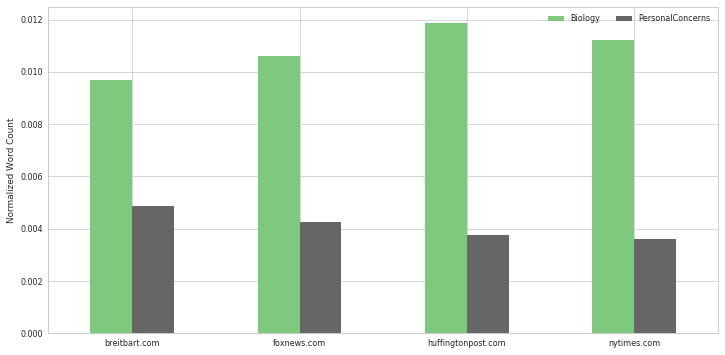

In [12]:
fig, ax = plt.subplots(figsize=(12,6))
df[['Biology','PersonalConcerns','source']].groupby('source').mean().plot.bar(ax=ax, colormap='Accent')
plt.xticks(rotation=0)
plt.xlabel('')
plt.legend(ncol=4)
plt.ylabel('Normalized Word Count')
plt.savefig('liwc.png', dpi=300)

#### MFD Comparisons

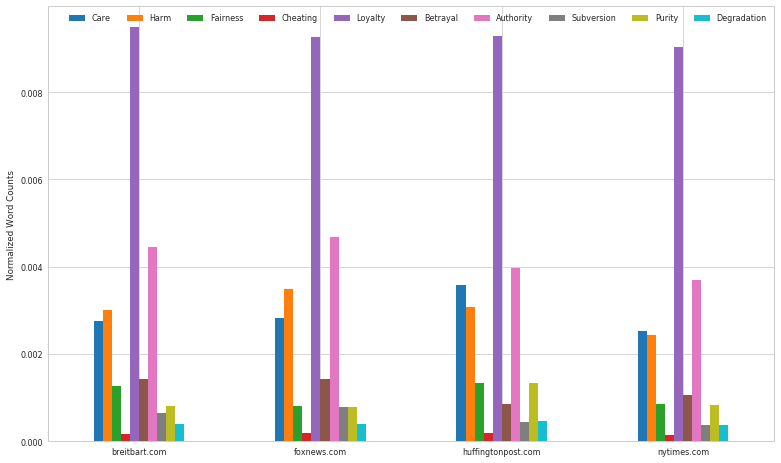

In [13]:
fig, ax = plt.subplots(figsize=(13,8))
df[foundations+['source']].groupby('source').mean().plot.bar(ax=ax)
plt.xticks(rotation=0)
plt.xlabel('')
plt.legend(ncol=10)
plt.ylabel('Normalized Word Counts')
plt.savefig('mfd.png', dpi=300)

### Analysis of Share Counts

In [14]:
df_shares = pd.read_pickle('data/climate_shares.pkl')

In [15]:
df_shares = df_shares['share_count']

In [16]:
df_shares = df_shares.reset_index()

In [17]:
df_shares = df_shares.rename(columns={'index':'url'})

In [18]:
df_shares = df_shares.set_index('url')

In [19]:
df = df.reset_index()
df = df.set_index('url')

In [20]:
matched = df.join(df_shares)

In [21]:
liberal = matched[matched.source.isin(['huffingtonpost.com','nytimes.com'])]
liberal = liberal[np.logical_and(liberal.share_count >= 1, liberal.share_count <= 1000)].sample(500, random_state=1)

In [22]:
cons = matched[matched.source.isin(['foxnews.com','breitbart.com'])]
cons = cons[np.logical_and(cons.share_count >= 1, cons.share_count <= 1000)].sample(500, random_state=2)

In [23]:
# Conservative negative binomial
model = smf.glm(formula = "share_count ~ Care+Harm+Fairness+Cheating+Loyalty+Betrayal+Authority+Subversion+Purity+Degradation", data=cons, family=sm.families.NegativeBinomial()).fit()
model.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
               Results: Generalized linear model
================================================================
Model:               GLM              AIC:            6076.1960 
Link Function:       log              BIC:            -1923.4554
Dependent Variable:  share_count      Log-Likelihood: -3027.1   
Date:                2018-11-28 15:11 LL-Null:        -3036.2   
No. Observations:    500              Deviance:       1115.5    
Df Model:            10               Pearson chi2:   957.      
Df Residuals:        489              Scale:          1.9573    
Method:              IRLS                                       
----------------------------------------------------------------
              Coef.   Std.Err.    z    P>|z|    [0.025   0.975] 
----------------------------------------------------------------
Intercept      5.1276   0.1301 39.4252 0.0000    4.8727   5.3826
Care           7.7175  15.2116  0.5073 0.6119  -22.0966  37.5316
Harm           6.9343  15.0965  0.4593 0.6460  -22.6544  36.5230
Fairness      20.7631  25.1459  0.8257 0.4090  -28.5219  70.0480
Cheating      20.7918 124.0713  0.1676 0.8669 -222.3835 263.9671
Loyalty      -16.7556   8.1937 -2.0450 0.0409  -32.8149  -0.6964
Betrayal       8.1823  19.7289  0.4147 0.6783  -30.4855  46.8502
Authority      4.5670  11.7822  0.3876 0.6983  -18.5256  27.6596
Subversion    -0.7670  24.4641 -0.0314 0.9750  -48.7157  47.1817
Purity        26.9118  26.2714  1.0244 0.3057  -24.5792  78.4028
Degradation -127.5405  52.9530 -2.4086 0.0160 -231.3264 -23.7546
================================================================

"""

In [24]:
# Liberal negative binomial
model = smf.glm(formula = "share_count ~ Care+Harm+Fairness+Cheating+Loyalty+Betrayal+Authority+Subversion+Purity+Degradation", data=liberal, family=sm.families.NegativeBinomial()).fit()
model.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
               Results: Generalized linear model
================================================================
Model:               GLM              AIC:            6327.5675 
Link Function:       log              BIC:            -2021.1543
Dependent Variable:  share_count      Log-Likelihood: -3152.8   
Date:                2018-11-28 15:11 LL-Null:        -3162.6   
No. Observations:    500              Deviance:       1017.8    
Df Model:            10               Pearson chi2:   743.      
Df Residuals:        489              Scale:          1.5189    
Method:              IRLS                                       
----------------------------------------------------------------
              Coef.   Std.Err.    z    P>|z|    [0.025   0.975] 
----------------------------------------------------------------
Intercept      5.2152   0.1150 45.3352 0.0000    4.9897   5.4407
Care          -6.5339  18.0600 -0.3618 0.7175  -41.9309  28.8631
Harm          24.0690  17.7501  1.3560 0.1751  -10.7207  58.8586
Fairness      -4.4555  24.5332 -0.1816 0.8559  -52.5397  43.6287
Cheating      79.8023  97.3967  0.8194 0.4126 -111.0917 270.6964
Loyalty        7.0412   7.7063  0.9137 0.3609   -8.0628  22.1453
Betrayal     -25.6674  28.8538 -0.8896 0.3737  -82.2198  30.8849
Authority      2.8751  15.8792  0.1811 0.8563  -28.2475  33.9977
Subversion  -186.2354  67.3968 -2.7633 0.0057 -318.3306 -54.1402
Purity        42.4109  24.9418  1.7004 0.0891   -6.4740  91.2959
Degradation  -33.0365  48.7982 -0.6770 0.4984 -128.6792  62.6062
================================================================

"""